In [1]:
# Step 0: Imports & Config
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


In [2]:
# Paths & hyperparams
DATA_ROOT  = "D:/AIML/data/flower_photos/flower_photos"
IMG_HEIGHT = 180
IMG_WIDTH  = 180
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

In [5]:
# Step 1: Load raw (unbatched) datasets
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=None,      # important: unbatched
    label_mode="int"
)
raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=None,
    label_mode="int"
)

# Capture class names & count
NUM_CLASSES = len(raw_train_ds.class_names)
class_names = raw_train_ds.class_names
print("Classes:", class_names, "Num of classes :", NUM_CLASSES)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] Num of classes : 5


In [6]:
# Step 2: Data-augmentation & preprocessing functions

# a) on-the-fly augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name="data_augmentation")

# b) ResNet-specific preprocessing (mean-subtraction etc.)
def preprocess(image, label, augment=False):
    # ensure float32
    image = tf.cast(image, tf.float32)
    # optional augment
    if augment:
        image = data_augmentation(image)
    # ResNet expects pixels in BGR order with mean subtracted
    image = resnet_preprocess(image)
    return image, label


In [7]:
# Step 3: Build tf.data pipelines
def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(1000, seed=42)
    ds = ds.map(lambda x,y: preprocess(x,y, augment), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = prepare(raw_train_ds, shuffle=True, augment=True)
val_ds   = prepare(raw_val_ds)


In [ ]:
# Step 4: Build the model with a frozen ResNet50 backbone
base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
base_model.trainable = False   # freeze entire backbone

# # Step 7: Unfreeze top layers & fine-tune
# base_model.trainable = True

# # Freeze all but the last convolutional block
# for layer in base_model.layers[:-10]:
#     layer.trainable = False


inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="input_image")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dropout(0.5, name="dropout")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="predictions")(x)

model = Model(inputs, outputs, name="resnet50_flowers")
model.summary()


94765736/94765736 [==============================] - 106s 1us/step
Model: "resnet50_flowers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 180, 180, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 gap (GlobalAveragePooling2  (None, 2048)              0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 predictions (Dense)         (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable param

In [9]:
# Step 5: Compile & callbacks for head training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    ModelCheckpoint("D:/AIML/data/resnet50_flowers_best.h5", monitor="val_accuracy", save_best_only=True),
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
]


In [10]:
# Step 6: Train just the new head
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
92/92 [==============================] - ETA: 0s - loss: 1.0588 - accuracy: 0.6226

d:\Softwares\anaconda\envs\homl3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - 144s 1s/step - loss: 1.0588 - accuracy: 0.6226 - val_loss: 0.4829 - val_accuracy: 0.8324 - lr: 0.0010
Epoch 2/10
92/92 [==============================] - 128s 1s/step - loss: 0.5698 - accuracy: 0.7939 - val_loss: 0.3712 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 3/10
92/92 [==============================] - 136s 1s/step - loss: 0.5043 - accuracy: 0.8202 - val_loss: 0.3532 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 4/10
92/92 [==============================] - 121s 1s/step - loss: 0.4552 - accuracy: 0.8389 - val_loss: 0.3125 - val_accuracy: 0.8896 - lr: 0.0010
Epoch 5/10
92/92 [==============================] - 119s 1s/step - loss: 0.4263 - accuracy: 0.8484 - val_loss: 0.3366 - val_accuracy: 0.8992 - lr: 0.0010
Epoch 6/10
92/92 [==============================] - 117s 1s/step - loss: 0.3822 - accuracy: 0.8621 - val_loss: 0.3329 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 7/10
92/92 [==============================] - 122s 1s/step - loss: 0.3655 - accur

23/23 [==============================] - 18s 767ms/step - loss: 0.2999 - accuracy: 0.9005

Final Validation Accuracy: 0.9005
1/1 [==============================] - 2s 2s/step


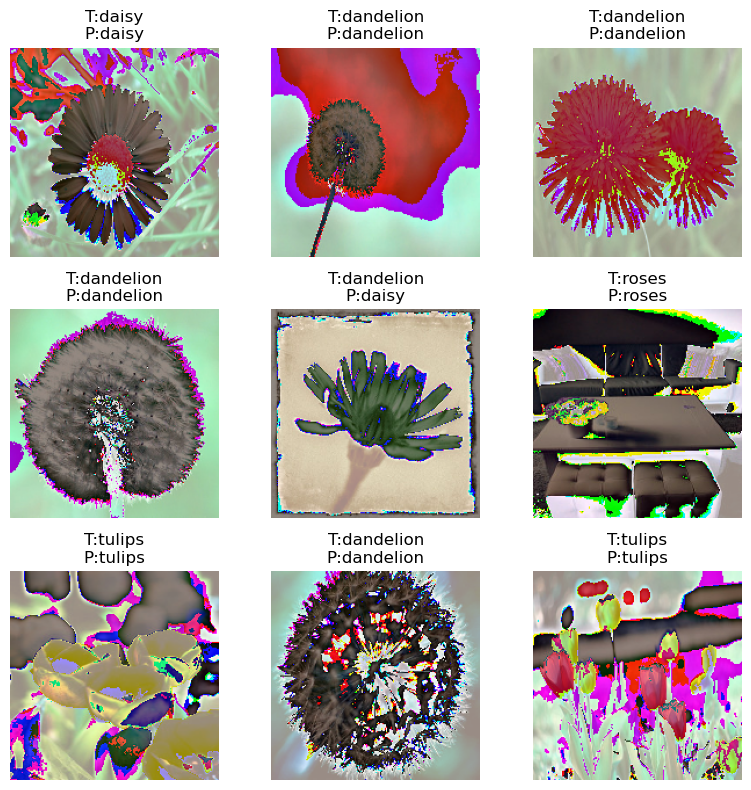

In [11]:
# Step 8: Evaluate & visualize
val_loss, val_acc = model.evaluate(val_ds)
print(f"\nFinal Validation Accuracy: {val_acc:.4f}")

# Show a few predictions
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1).numpy()
    plt.figure(figsize=(8,8))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"T:{class_names[labels[i]]}\nP:{class_names[pred_labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break


1/1 [==============================] - 1s 846ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


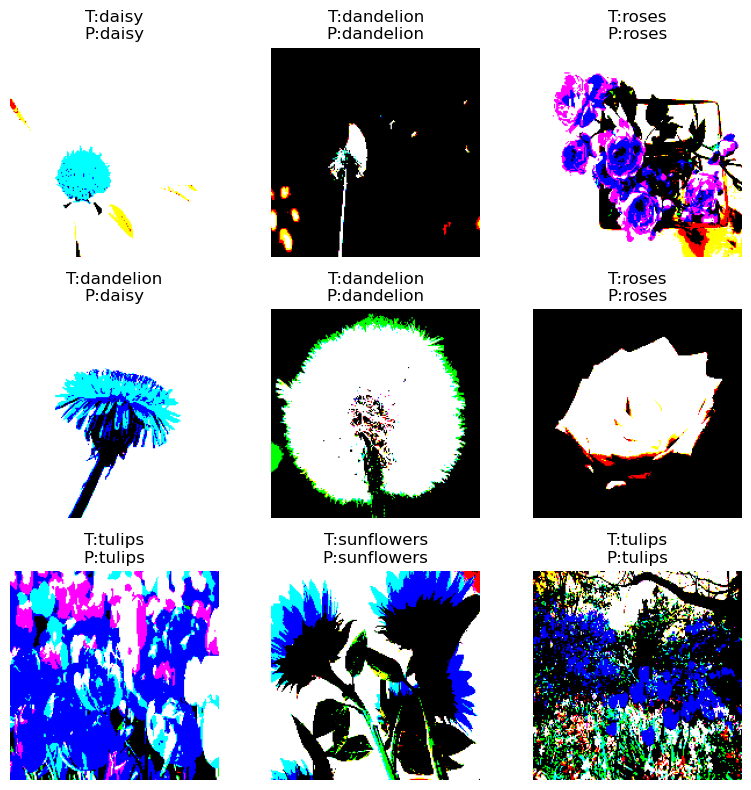

In [12]:
# Step 9: Visualize a few predictions
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1).numpy()

    plt.figure(figsize=(8,8))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy())
        # Use the standalone class_names, not train_ds.class_names
        plt.title(f"T:{class_names[labels[i]]}\nP:{class_names[pred_labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break
